# Feature creation and selection

In [7]:
######################## LOAD IN FILES #############################
import os
import pandas as pd
import sys
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path for script usage
sys.path.append(project_root)

# Import and reload (optional) custom scripts
# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
from scripts import variables as var
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(var)

############ LOAD in PACKAGES  #############
import numpy as np
from sklearn.linear_model import LogisticRegression


################ DEFINE column variables from data ###################
from scripts.variables import id_columns, demographic_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols
from scripts.variables import df_names, df_names_with_mis


## Create wide versions of each vars list
wide_v1_cols = []
for var in daily_cols_v1:
    wide_v1_cols.append(f'{var}_avg_w1')
    wide_v1_cols.append(f'{var}_avg_w2')
    wide_v1_cols.append(f'{var}_slope_w2')
    wide_v1_cols.append(f'{var}_avg_w4')
    wide_v1_cols.append(f'{var}_slope_w4')

wide_v2_cols = []
for var in daily_v2_common:
    wide_v2_cols.append(f'{var}_avg_w1')
    wide_v2_cols.append(f'{var}_avg_w2')
    wide_v2_cols.append(f'{var}_slope_w2')
    wide_v2_cols.append(f'{var}_avg_w4')
    wide_v2_cols.append(f'{var}_slope_w4')


# Remove v2 week becaues there wasn't enoguh for train/test sets
df_names.remove('v2_week')


## Feature Selection for non-DT ML Pipelines



For v1_day:


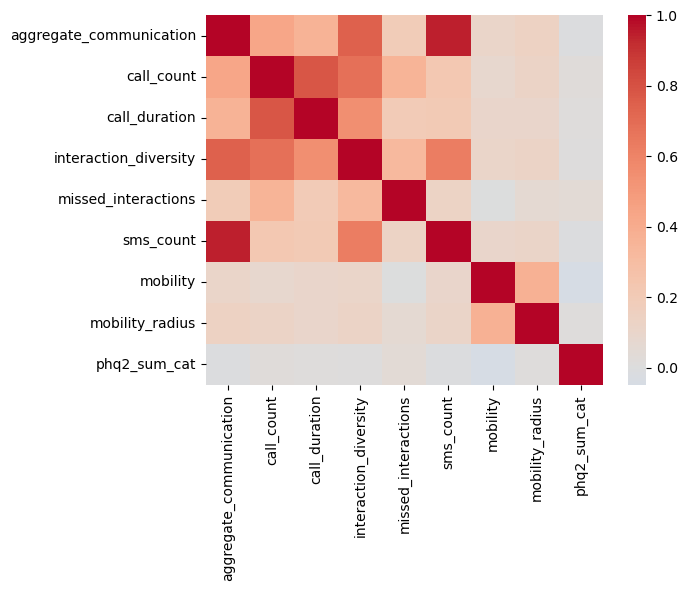



For v2_day:


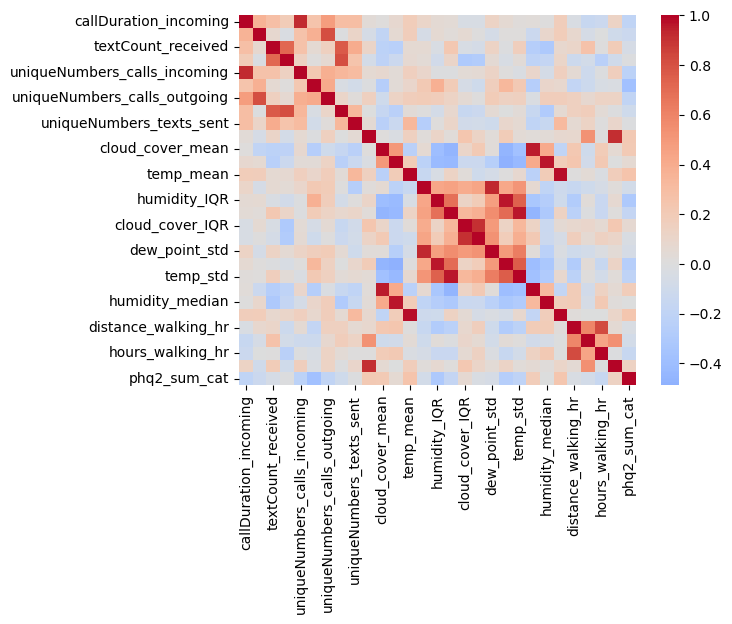



For v1_week:


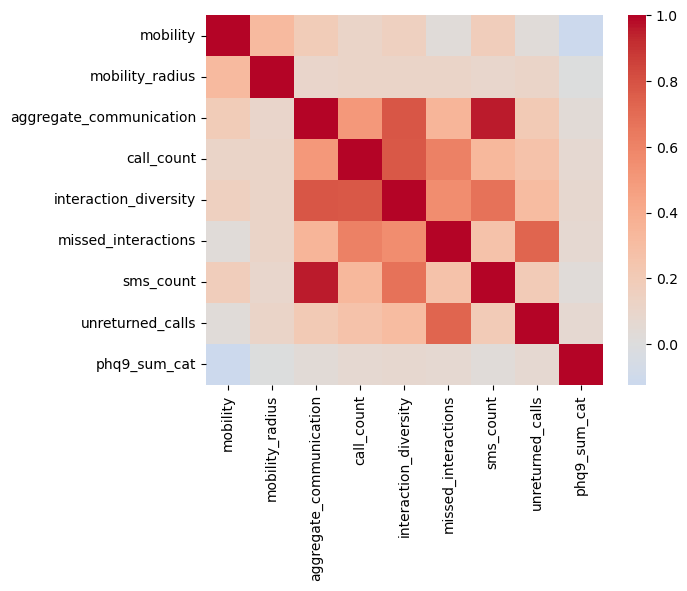

In [9]:
for name in df_names:
    X_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    y_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
    train = pd.concat([X_train, y_train], axis=1)
    train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in train.columns.to_list() if col not in id_columns and col not in demographic_columns]
    sns.heatmap(train[numeric_cols].corr(), cmap="coolwarm", center=0)
    plt.show()

Looks like there's significant correlation between sms count the other phone features, so we'll drop that. 



For v1_day:


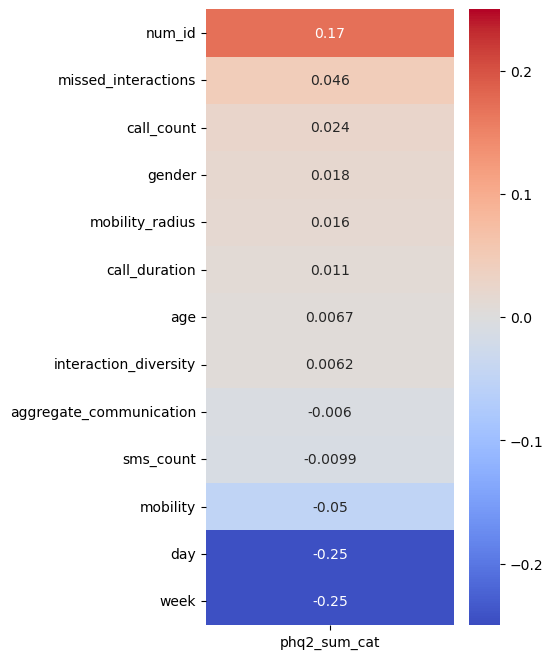



For v2_day:


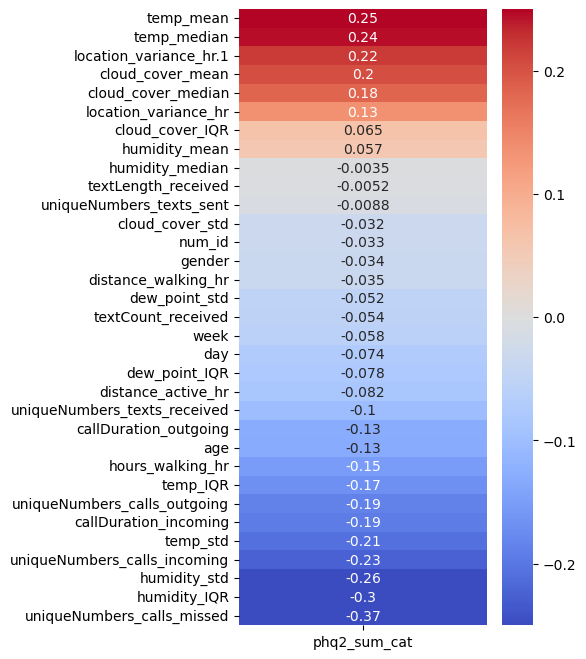



For v1_week:


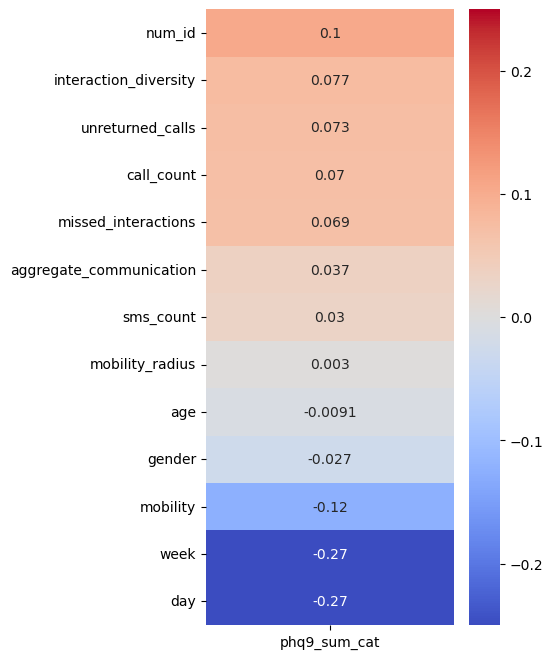

In [14]:
for name in df_names:
    target = 'phq9_sum_cat'
    if 'day' in name:
        target = 'phq2_sum_cat'
    X_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    y_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
    y_train.name = target
    train = pd.concat([X_train, y_train], axis=1)
    train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
    print(f'\n\nFor {name}:')

    fig, ax = plt.subplots(figsize=(4, 8))
    corr_matrix = train.corr(numeric_only=True).sort_values(by=target,ascending=False)
    corr_matrix = corr_matrix.drop(target)
    sns.heatmap(corr_matrix[[target]],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)
    plt.show()

## Feature Selection for Decision Trees wide features

In [ ]:
wide_dfs_clusters = {}
for name in df_names:
    wide_dfs_clusters[name] = pd.read_csv(os.path.join(brighten_dir, f'wide_{name}_clusters.csv'))


In [13]:

from sklearn.feature_selection import VarianceThreshold

# Define feature and target columns
X_cols = [col for col in wide_dfs_clusters['v1_day'] if 'depression' not in col and 'phq2' not in col and col not in id_columns]
y_col = 'phq2_bin_avg_w4'

# Create DataFrame with relevant columns
lr_df = wide_dfs_clusters['v1_day'][['num_id', y_col] + X_cols]

# Display correlation matrix
corr_matrix = lr_df[X_cols + [y_col]].corr().abs()

# Apply Variance Threshold to drop low-variance features
selector = VarianceThreshold(threshold=0.005)  # Adjust as needed
X_selected = selector.fit_transform(lr_df[X_cols])  # Returns a NumPy array

# Get names of selected columns
selected_columns = [X_cols[i] for i in range(len(X_cols)) if selector.get_support()[i]]
dropped_columns = list(set(X_cols) - set(selected_columns))

print(f"Dropped low-variance features: {dropped_columns}")

# Convert selected features back to DataFrame for correlation analysis
df_filtered = lr_df[['num_id', y_col] + selected_columns]

# Compute correlation matrix (absolute values)
corr_matrix = df_filtered.corr().abs()

# Zero out the diagonal (self-correlation)
np.fill_diagonal(corr_matrix.values, 0)
corr_matrix.to_csv(os.path.join(brighten_dir, 'wide_v1Day_highVar_corrMatrix.csv'))

# Define threshold for high correlation (e.g., 0.9)
threshold = 0.9

# Get correlation of features with target variable
target_corr = corr_matrix[y_col].sort_values(ascending=False)

# Identify highly correlated feature pairs
to_drop = set()
for col in corr_matrix.columns:
    if col == y_col:  
        continue  # Skip target variable
    if 'Unnamed' in col:
        to_drop.add(col)
    # Find features highly correlated with the current feature
    high_corr_features = corr_matrix.index[(corr_matrix[col] > threshold)].tolist()
    
    # Remove features but keep the one most correlated with the target
    for feature in high_corr_features:
        if target_corr[col] >= target_corr[feature]:  # Keep the stronger predictor
            to_drop.add(feature)
        else:
            to_drop.add(col)

# Drop selected features
df_selected = df_filtered.drop(columns=to_drop)

print(f"Dropped {len(to_drop)} highly correlated features: {to_drop}")

display(df_selected)

Dropped low-variance features: ['aggregate_communication_slope_wu4', 'pc_mobility_slope_wu4', 'gender_slope_wu4', 'sms_length_slope_wu4', 'sms_count_slope_wu2', 'unreturned_calls_slope_wu4', 'aggregate_communication_slope_wu2', 'call_duration_slope_wu2', 'gender_slope_wu2', 'pc_communication_slope_wu4', 'call_count_slope_wu4', 'call_count_slope_wu2', 'age_slope_wu2', 'interaction_diversity_slope_wu2', 'sms_length_slope_wu2', 'mobility_radius_slope_wu4', 'interaction_diversity_slope_wu4', 'call_duration_slope_wu4', 'pc_missed_communications_slope_wu4', 'sms_count_slope_wu4', 'mobility_slope_wu4', 'missed_interactions_slope_wu4', 'age_slope_wu4']
Dropped 41 highly correlated features: {'sms_length_avg_wu2', 'Unnamed: 0.2', 'missed_interactions_avg_wu4', 'call_count_avg_wu4', 'Unnamed: 0', 'Unnamed: 0_avg_w1', 'interaction_diversity_avg_wu4', 'sms_count_avg_wu2', 'age_avg_w1', 'Unnamed: 0_avg_w4', 'age_avg_wu2', 'call_count_avg_w1', 'pc_missed_communications_avg_wu2', 'interaction_diversi

,num_id,phq2_bin_avg_w4,mobility_radius_avg_w1,mobility_radius_avg_wu2,mobility_radius_slope_wu2,mobility_radius_avg_w4,mobility_avg_w1,mobility_avg_wu2,mobility_slope_wu2,mobility_avg_wu4,...,pc_communication_avg_wu2,pc_communication_slope_wu2,pc_communication_avg_w4,sms_length_avg_wu4,sms_length_avg_w4,missed_interactions_avg_w1,missed_interactions_avg_wu2,missed_interactions_slope_wu2,missed_interactions_avg_w4,Cluster
0,37,1.0,-0.639849,-0.437350,0.051625,-0.632979,-0.891471,-0.632216,0.070927,-0.358858,...,-0.563933,0.129521,4.580347,-0.088409,-0.630039,0.469767,0.671592,6.847550e-02,2.953768,4
1,52,0.0,0.352328,0.313849,0.009279,0.226914,0.394189,0.031699,-0.121871,-0.085917,...,0.788865,0.136002,0.233416,1.893654,1.454170,-0.209004,-0.232292,-2.215705e-02,-0.535029,1
2,79,1.0,-0.350012,-0.520082,-0.113380,-0.715425,-0.236475,-0.540820,-0.202896,-0.701050,...,-0.288701,0.763227,-1.687485,-0.593531,-0.751703,0.562917,1.214967,4.347002e-01,-0.741184,1
3,81,0.0,-0.206126,-0.264372,-0.011379,-0.311790,0.029990,-0.110679,-0.013414,-0.060727,...,-1.172218,0.014330,0.126717,-1.016145,-1.051660,-0.502155,-0.387508,2.279896e-02,-0.409005,1
4,103,0.0,0.224917,0.403683,0.031383,-0.071410,-0.281626,-0.264452,0.007458,-0.466709,...,0.397045,-0.076457,0.678654,-0.874971,-0.980638,0.378793,0.476601,3.706391e-02,0.422263,0
5,113,1.0,-0.632639,0.267115,0.245187,-0.576333,-0.409998,0.029867,0.159633,1.347400,...,0.270857,-0.021487,-0.208618,-0.019267,-0.151479,-0.127482,-0.344832,-5.732310e-02,-0.290494,3
6,148,0.0,0.772031,0.790430,0.028312,0.852107,0.293532,0.311130,0.003695,0.346489,...,0.067278,-0.062628,0.790426,-0.400400,-0.788579,0.832996,1.122796,1.423751e-01,1.104683,2
7,1259,0.0,0.518377,0.562798,0.023536,0.946669,0.386205,0.180342,0.005150,0.303479,...,-0.898151,0.163814,-0.297126,0.826587,0.917171,-0.399910,-0.436135,-2.128454e-02,-0.240519,6
8,1284,0.0,0.702531,0.928176,0.085758,0.639552,0.114182,0.622931,0.142962,0.588209,...,-0.234374,-0.102786,-1.728100,-0.662176,-0.650590,0.284827,-0.171608,-9.764204e-02,-0.041198,6
9,1295,0.0,-0.675114,-0.674894,-0.000811,-0.446073,0.980600,0.891440,-0.038758,0.747267,...,-1.729704,-0.036554,-0.560899,-0.703364,-0.716492,-0.745977,-0.528627,3.493126e-02,0.395111,1


In [17]:
# PHQ9 Cat, phq9 cat change
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scale_columns = [col for col in df_selected.columns if col not in ['num_id', y_col]]
print(f"Scaling columns: {scale_columns}")
X_scaled = pd.DataFrame(scaler.fit_transform(lr_df[scale_columns]), columns=scale_columns)

y = lr_df[y_col].copy()

# Apply Randomized Logistic Regression
selected_features, feature_importances = fs.randomized_logistic_regression(X_scaled, y)

# Print selected feature indices
print(f"Selected Features: {selected_features}")
print(f"Feature Importances: {feature_importances}")


Scaling columns: ['mobility_radius_avg_w1', 'mobility_radius_avg_wu2', 'mobility_radius_slope_wu2', 'mobility_radius_avg_w4', 'mobility_avg_w1', 'mobility_avg_wu2', 'mobility_slope_wu2', 'mobility_avg_wu4', 'mobility_avg_w4', 'unreturned_calls_avg_w1', 'unreturned_calls_slope_wu2', 'unreturned_calls_avg_wu4', 'unreturned_calls_avg_w4', 'pc_missed_communications_avg_w1', 'pc_missed_communications_slope_wu2', 'pc_missed_communications_avg_wu4', 'pc_missed_communications_avg_w4', 'pc_mobility_avg_wu2', 'pc_mobility_slope_wu2', 'pc_mobility_avg_w4', 'interaction_diversity_avg_wu2', 'interaction_diversity_avg_w4', 'call_duration_avg_w1', 'call_duration_avg_w4', 'call_count_avg_wu2', 'call_count_avg_w4', 'pc_communication_avg_wu2', 'pc_communication_slope_wu2', 'pc_communication_avg_w4', 'sms_length_avg_wu4', 'sms_length_avg_w4', 'missed_interactions_avg_w1', 'missed_interactions_avg_wu2', 'missed_interactions_slope_wu2', 'missed_interactions_avg_w4', 'Cluster']
Selected Features: ['mobility